In [5]:
!pip install -q pandas
import pandas as pd

df = pd.read_csv('data/train_data.csv')
df = df.dropna()

df.head(5)

,x,y,z,t0,t1,t2,t3,xc_px,yc_px,xc,yc,diagonal
7,0.16,-0.19,0.12,30.100908,33.948155,75.041009,41.092854,-275.0,145.0,4.950,2.610,73.389373
8,0.17,-0.18,0.12,33.363423,34.952635,76.655631,41.702995,-264.0,160.0,4.752,2.880,72.801099
9,0.18,-0.17,0.12,36.636577,34.952635,76.655631,41.702995,-249.0,178.0,4.482,3.204,72.780492
10,0.19,-0.16,0.12,39.899092,33.948155,75.041009,41.092854,-235.0,191.0,4.230,3.438,72.835431
11,0.20,-0.15,0.12,43.130102,31.753588,71.469230,39.715641,-222.0,208.0,3.996,3.744,75.239617


In [7]:
from utils.functions import mapping, ikine
l1, l2, l3 = 0.1, 0.124, 0.06 
import numpy as np

def simulate_travel(start:tuple[float, float], end:tuple[float, float], travel_points:list[float]):
    xi, yi = start
    xf, yf = end
    
    t0, t1, t2, t3, _, _ = mapping(ikine([xi, yi, .12], l1, l2, l3))
    data = {
        "t0i":  t0,
        "t1i":  t1,
        "t2i":  t2,
        "t3i":  t3,
        "xi"  : xi,
        "yi"  : yi,
    }
    
    
    for point in travel_points:
        x = xi + point * (xf-xi)
        y = yi + point * (yf-yi)
        
        t0, t1, t2, t3, _, _ = mapping(ikine([x, y, .12], l1, l2, l3))
        data.update({
            f"t0{point:.2f}" : t0,
            f"t1{point:.2f}":  t1,
            f"t2{point:.2f}":  t2,
            f"t3{point:.2f}":  t3,
            f"x{point:.2f}"  : x,
            f"y{point:.2f}"  : y,
        })
    
    t0, t1, t2, t3, _, _ = mapping(ikine([x, y, .12], l1, l2, l3))
    data.update({
        f"t0f": t0,
        f"t1f": t1,
        f"t2f": t2,
        f"t3f": t3,
        f"xf"  : xf,
        f"yf"  : yf,
    })
    
    return data

def get_data_train(n_samples=None, travel_points=[0.3, 0.5, 0.75, 0.825, 0.9, 0.95], x_start:float=0.035, y_start:float=0)->pd.DataFrame:
    if n_samples is None:
        points = df[['x', 'y']].values
    else:
        x_range, y_range = (df['x'].min(), df['x'].max()), (df['y'].min(), df['y'].max())
        points = np.column_stack((np.random.uniform(*x_range,  n_samples), np.random.uniform(*y_range, n_samples)))
        
    data = []
    for point in points:
        try:
            travel = simulate_travel((x_start, y_start), point, travel_points)
            data.append(travel)
        except:
            pass
    
    return pd.DataFrame(data)

In [16]:
narx_train_dataset = get_data_train() 
narx_train_values = get_data_train(2000)
narx_train_dataset.to_csv("data/narx_train_dataset.csv", index=False)

## Treinamento após coleta de dados

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from utils.narxwithga import NARXModel 
import random
from utils.ga import GeneticAlgorithm
import joblib

# Load and clean data
df = pd.read_csv('data/train_data.csv')
df = df.dropna().reset_index(drop=True)

In [5]:
# Set delays
output_delay = 1
input_delay = 1

In [6]:
# Prepare raw input and output
X_raw = df[['t0', 't1', 't2', 't3']].values 
Y_raw = df[['x', 'y']].values  

In [7]:
# Build NARX-style delayed inputs
X_new = []
Y_new = []

for t in range(max(input_delay, output_delay), len(X_raw)):
    delayed_inputs = X_raw[t - input_delay:t].flatten()
    delayed_outputs = Y_raw[t - output_delay:t].flatten()
    current_input = X_raw[t]
    combined_input = np.concatenate([delayed_inputs, delayed_outputs, current_input])
    X_new.append(combined_input)
    Y_new.append(Y_raw[t])

X_new = np.array(X_new)
Y_new = np.array(Y_new)

# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, test_size=0.25, random_state=42)

# Normalize inputs/outputs
input_scaler = StandardScaler()
X_train_norm = input_scaler.fit_transform(X_train)
X_test_norm = input_scaler.transform(X_test)

output_scaler = StandardScaler()
Y_train_norm = output_scaler.fit_transform(Y_train)
Y_test_norm = output_scaler.transform(Y_test)

np.save('X_test_norm.npy', X_test_norm)
np.save('Y_test_norm.npy', Y_test_norm)
np.save('Y_test.npy', Y_test)
joblib.dump(output_scaler, 'output_scaler.pkl')

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_train_norm, dtype=torch.float32)
Y_tensor = torch.tensor(Y_train_norm, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_norm, dtype=torch.float32)

# Determine input dimension
input_dim = input_delay * X_raw.shape[1] + output_delay * Y_raw.shape[1] + X_raw.shape[1]

# Run Genetic Algorithm
ga = GeneticAlgorithm(
    population_size=100,
    mutation_rate=0.2,
    crossover_rate=0.5,
    input_dim=input_dim,
    X_tensor=X_tensor,
    Y_tensor=Y_tensor,
    tournament_size=3
)


best_model = ga.run(generations=1000)
torch.save(best_model.state_dict(), 'best_ga_model.pth')
print("Model saved to 'best_ga_model.pth'")

with torch.no_grad():
    # Test predictions
    predictions = best_model(X_test_tensor).numpy()
    predictions_original = output_scaler.inverse_transform(predictions)
    Y_test_original = output_scaler.inverse_transform(Y_test_norm)

    # Train predictions
    preds_train_norm = best_model(X_tensor).numpy()
    preds_train = output_scaler.inverse_transform(preds_train_norm)
    Y_train_true = output_scaler.inverse_transform(Y_tensor.numpy())

# --- Evaluation ---

# Train metrics
train_mse  = mean_squared_error(Y_train_true, preds_train)
train_rmse = np.sqrt(train_mse)
train_mae  = mean_absolute_error(Y_train_true, preds_train)
train_r2   = r2_score(Y_train_true, preds_train)

print("\nTrain set performance:")
print(f"MSE : {train_mse:.5f}")
print(f"RMSE: {train_rmse:.5f}")
print(f"MAE : {train_mae:.5f}")
print(f"R^2 : {train_r2:.5f}")


# Test metrics
mse = mean_squared_error(Y_test_original, predictions_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test_original, predictions_original)
r2 = r2_score(Y_test_original, predictions_original)

print("Evaluation Metrics on Test Data:")
print(f"MSE : {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE : {mae:.5f}")
print(f"R^2 : {r2:.5f}")

Generation 1, Best Fitness (MSE): 1.49137
Generation 2, Best Fitness (MSE): 0.88980
Generation 3, Best Fitness (MSE): 0.88980
Generation 4, Best Fitness (MSE): 0.88980
Generation 5, Best Fitness (MSE): 0.88980
Generation 6, Best Fitness (MSE): 0.68025
Generation 7, Best Fitness (MSE): 0.67135
Generation 8, Best Fitness (MSE): 0.61204
Generation 9, Best Fitness (MSE): 0.61204
Generation 10, Best Fitness (MSE): 0.61204
Generation 11, Best Fitness (MSE): 0.44709
Generation 12, Best Fitness (MSE): 0.44709
Generation 13, Best Fitness (MSE): 0.43447
Generation 14, Best Fitness (MSE): 0.43201
Generation 15, Best Fitness (MSE): 0.36507
Generation 16, Best Fitness (MSE): 0.32664
Generation 17, Best Fitness (MSE): 0.29457
Generation 18, Best Fitness (MSE): 0.29457
Generation 19, Best Fitness (MSE): 0.29457
Generation 20, Best Fitness (MSE): 0.29457
Generation 21, Best Fitness (MSE): 0.27913
Generation 22, Best Fitness (MSE): 0.25573
Generation 23, Best Fitness (MSE): 0.23749
Generation 24, Best 

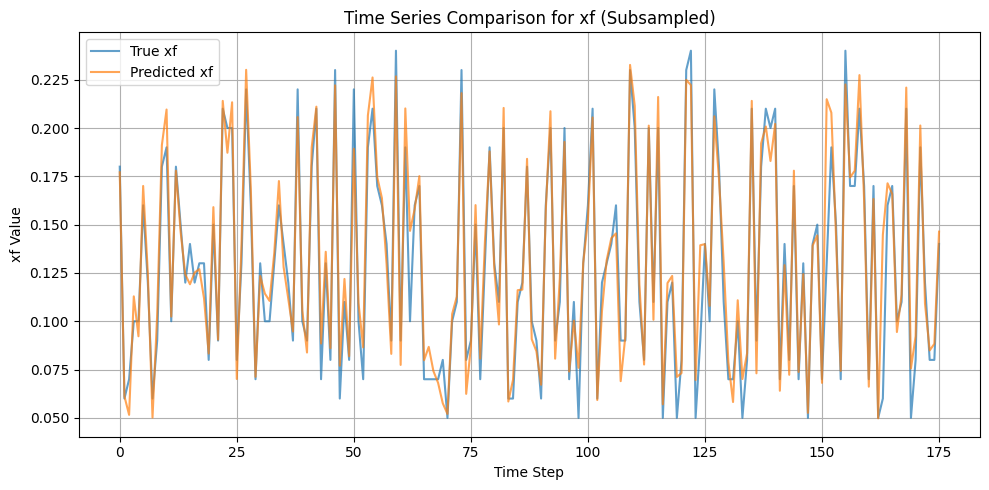

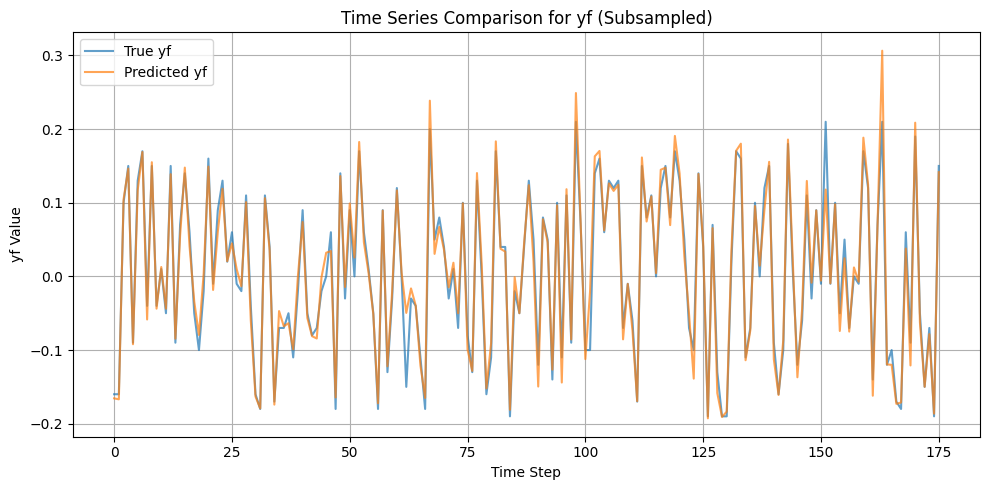

In [8]:
# --- Plotting ---

step = 1
time_steps = np.arange(0, len(Y_test_original), step)

plt.figure(figsize=(10, 5))
plt.plot(time_steps, Y_test_original[::step, 0], label='True xf', alpha=0.7)
plt.plot(time_steps, predictions_original[::step, 0], label='Predicted xf', alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("xf Value")
plt.title("Time Series Comparison for xf (Subsampled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(time_steps, Y_test_original[::step, 1], label='True yf', alpha=0.7)
plt.plot(time_steps, predictions_original[::step, 1], label='Predicted yf', alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("yf Value")
plt.title("Time Series Comparison for yf (Subsampled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
X_test_norm = np.load("X_test_norm.npy")
Y_test_norm = np.load("Y_test_norm.npy")  # assuming this is still normalized
Y_test = np.load("Y_test.npy")  # assuming this is still normalized
output_scaler = joblib.load('output_scaler.pkl')
input_dim = X_test_norm.shape[1]

X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)


model = NARXModel(input_dim=input_dim, output_dim=2)  # output_dim=2 for (x, y)
model.load_state_dict(torch.load("best_ga_model.pth"))
model.eval()


# ---- Predict ----
max_delay = max(input_delay, output_delay)
rand_index = random.randint(max_delay, len(X_test_norm) - 1)

# Prepare delayed input
delayed_inputs = X_raw[rand_index - input_delay:rand_index].flatten()
delayed_outputs = Y_raw[rand_index - output_delay:rand_index].flatten()
current_input = X_raw[rand_index]
combined_input = np.concatenate([delayed_inputs, delayed_outputs, current_input])

# Normalize and predict
# Choose a random test index
rand_test_index = random.randint(0, len(X_test_norm) - 1)

# Get the normalized input and true output from test set
input_tensor = torch.tensor(X_test_norm[rand_test_index:rand_test_index+1], dtype=torch.float32)
true_output = Y_test[rand_test_index]  # Already unnormalized

# Predict
model.eval()
with torch.no_grad():
    pred_scaled = model(input_tensor).numpy()
    pred_original = output_scaler.inverse_transform(pred_scaled)

# Output prediction and ground truth
print(f"Predicted (x, y): {pred_original[0]}")
print(f"True (x, y): {true_output}")


Predicted (x, y): [ 0.10241514 -0.04381124]
True (x, y): [ 0.1  -0.05]
